In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
import statsmodels.api as sm

# import chemO_funcs #import o2sat
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
# %run ./chemO_funcs.py

# Dataset updated to have surface variables (e.g. `phos`)

In [8]:
ds1 = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4future_2015_2035.nc')

In [5]:
ds2 = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4_2035_2060.nc')

In [9]:
ds = xr.concat([ds1, ds2], dim="time")

# Detrending from Year 2000

In [10]:
ds['fCO2_detrended'] = (ds['fCO2'] -  1.89 * (ds['fCO2'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['ph_detrended'] = (ds['phos'] + 0.0018 * (ds['phos'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['OmegaAr_detrended'] = (ds['OmegaAr'] + 0.0078 * (ds['OmegaAr'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])

In [11]:
# ds['fugacity_detrended'] = xr.Variable(dims = ['time','y', 'x'], data = ds['fugacity'] -  1.89 * (ds['fugacity'].time.dt.year - 1980))
ds['fCO2_detrended'].attrs = {"units": 'uatm', 
                        'description': 'detrended fugacity. 1.89 uatm subtracted for every year since 2000',
                                 'name': 'fugacity detrended'}
ds['ph_detrended'].attrs = {"units": '', 'name': 'pH detrended', 
                        'description': 'detrended pH on total scale. 0.0018 added for every year since 2000'}
ds['OmegaAr_detrended'].attrs = {"units": '', 'name': 'Omega_arag detrended', 
                        'description': 'detrended Omega_arag calculated from PyCO2SYS: 0.0078 added for every year since 2000'}

In [47]:
ds

<xarray.Dataset>
Dimensions:            (time: 540, y: 180, x: 360)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 -90.0 -90.0 -90.0 -90.0 ... 89.0 89.0 89.0
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 360.0 360.0 360.0 ... 359.0 359.0 359.0
  * time               (time) object 2015-01-16 12:00:00 ... 2059-12-16 12:00:00
    time_bounds        (time) object dask.array<chunksize=(240,), meta=np.ndarray>
    lon                (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    lat                (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies      (x, y) float64 360.0 360.0 360.0 ... 359.0 359.0 359.0
    lat_verticies      (x, y) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
    member_id          <U8 'r1i1p1f1'
    dcpp_init_year     float64 nan
Data variables:
    talkos             (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    dissicos           (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    tos                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    sos                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    phos               (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    sigma0             (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fCO2               (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    OmegaAr            (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fCO2_detrended     (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    ph_detrended       (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    OmegaAr_detrended  (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60225.0
    branch_time_in_parent:            60225.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   ssp245
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr

In [50]:
annualmean = ds.groupby('time.year').mean('time')
annualstd = ds.groupby('time.year').std('time')

In [6]:
dsmean = ds.mean('time', keep_attrs = True)
dsstd = ds.std('time', keep_attrs = True)

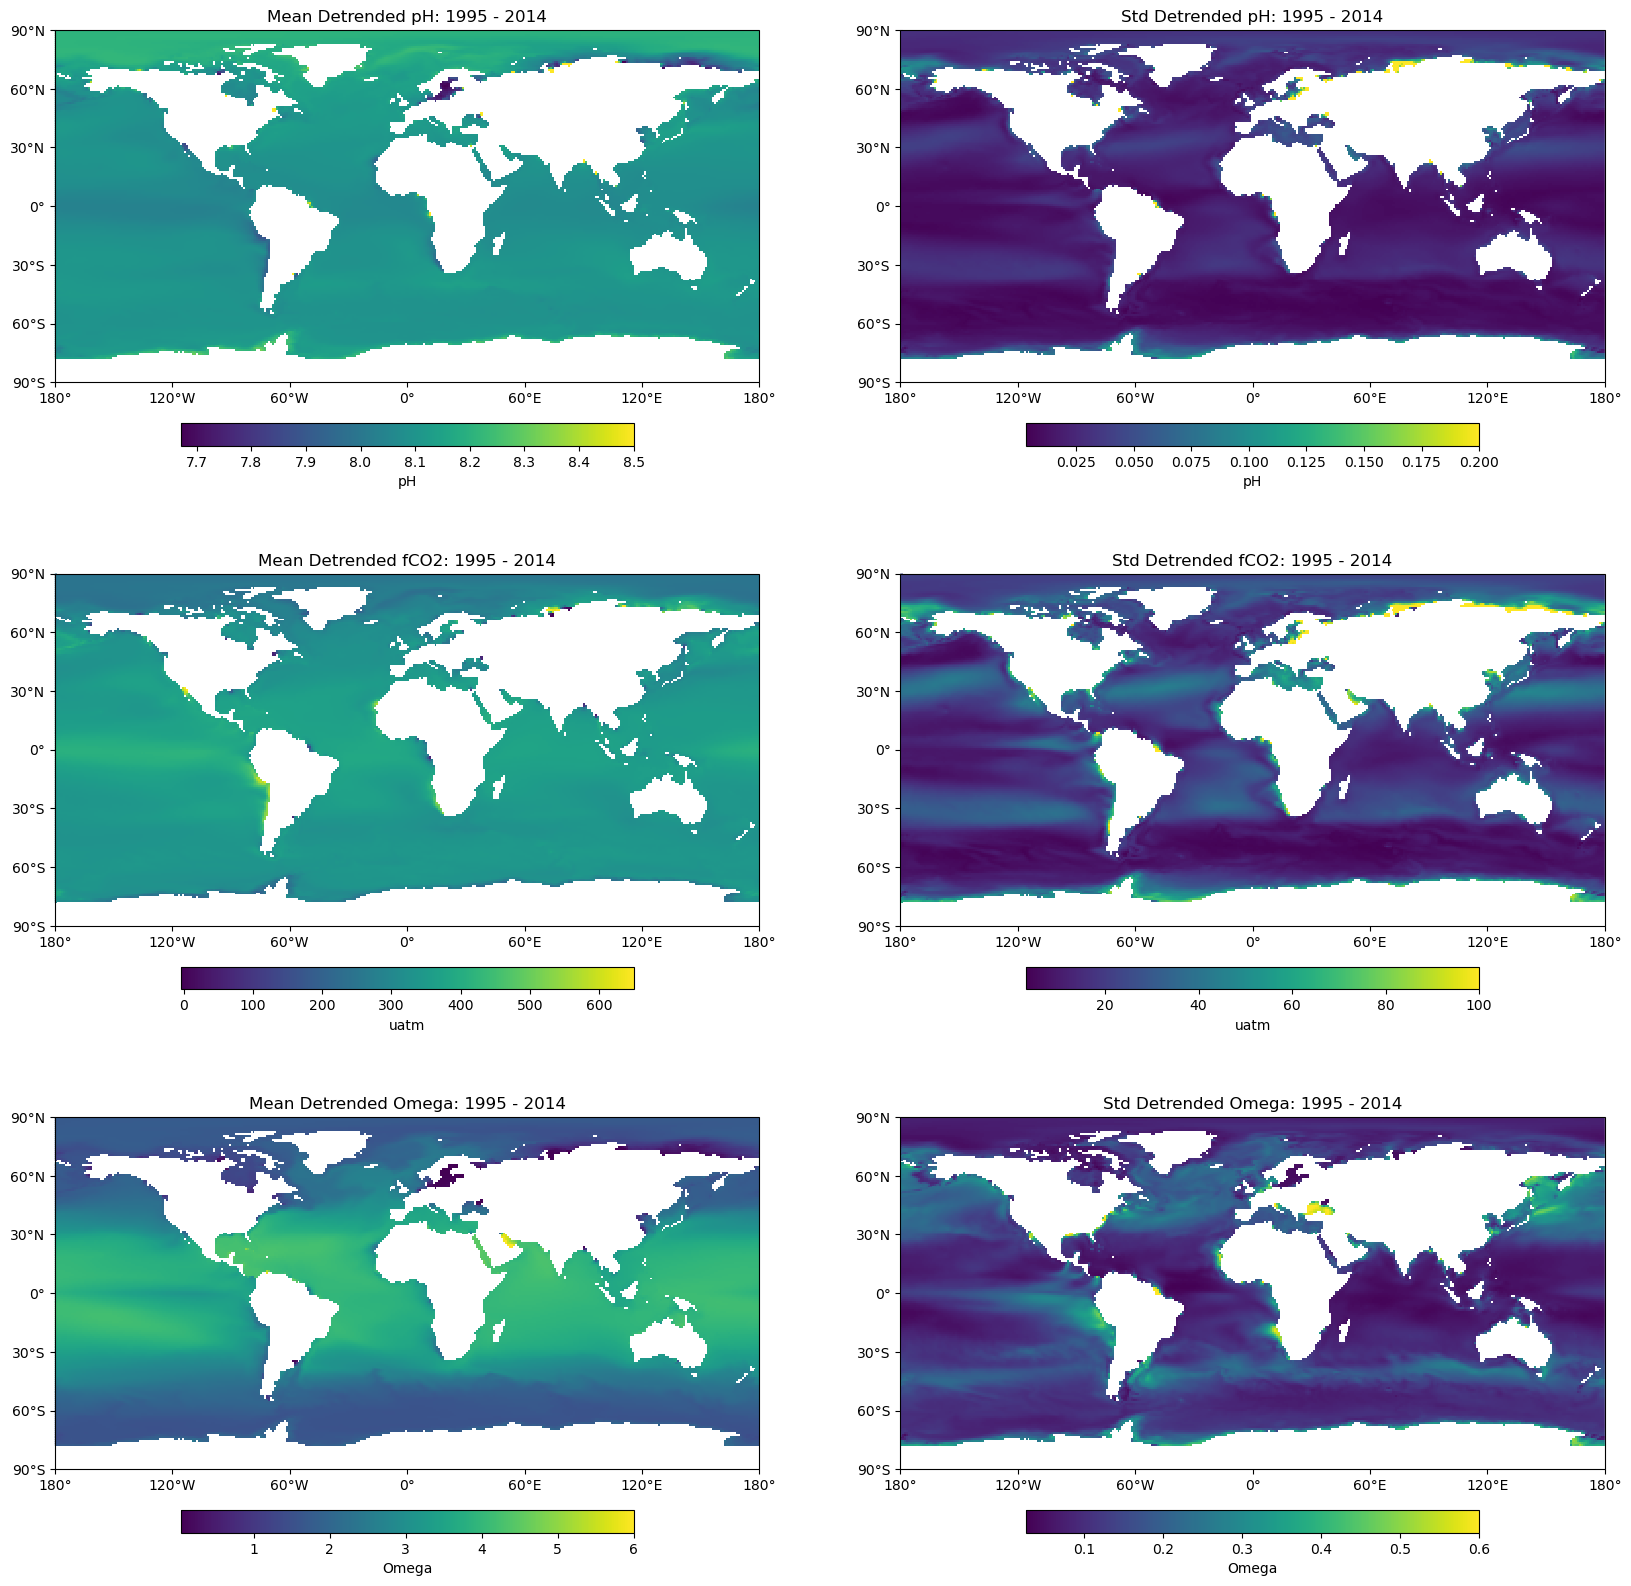

In [7]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = [20,20],subplot_kw={'projection':ccrs.PlateCarree()})

axs = axs.flatten()

# Plot of mean detrended pH
phmean = axs[0].pcolormesh(dsmean.x, dsmean.y, dsmean.ph_detrended, vmax = 8.5)
cbar0 = plt.colorbar(phmean, ax = axs[0], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar0.set_label('pH')
axs[0].set_title('Mean Detrended pH: 1995 - 2014')

# Plot of detrended pH Std
phstd = axs[1].pcolormesh(dsstd.x, dsstd.y, dsstd.ph_detrended, vmax = 0.2)
cbar1 = plt.colorbar(phstd, ax = axs[1], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar1.set_label('pH')
axs[1].set_title('Std Detrended pH: 1995 - 2014')

# Plot of mean detrended fugacity
fco2mean = axs[2].pcolormesh(dsmean.x, dsmean.y, dsmean.fCO2_detrended, vmax = 650)
cbar2 = plt.colorbar(fco2mean, ax = axs[2], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar2.set_label(dsmean.fCO2_detrended.units)
axs[2].set_title('Mean Detrended fCO2: 1995 - 2014')

# Plot of detrended fugacity Std
fco2std = axs[3].pcolormesh(dsstd.x, dsstd.y, dsstd.fCO2_detrended, vmax = 100)
cbar3 = plt.colorbar(fco2std, ax = axs[3], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar3.set_label(dsstd.fCO2_detrended.units)
axs[3].set_title('Std Detrended fCO2: 1995 - 2014')

# Plot of mean detrended omega aragonite
omegamean = axs[4].pcolormesh(dsmean.x, dsmean.y, dsmean.OmegaAr_detrended, vmax = 6)
cbar4 = plt.colorbar(omegamean, ax = axs[4], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar4.set_label('Omega')
axs[4].set_title('Mean Detrended Omega: 1995 - 2014')

# Plot of detrended omega aragonite Std
omegastd = axs[5].pcolormesh(dsstd.x, dsstd.y, dsstd.OmegaAr_detrended, vmax = 0.6)
cbar5 = plt.colorbar(omegastd, ax = axs[5], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar5.set_label('Omega')
axs[5].set_title('Std Detrended Omega: 1995 - 2014')

axlist = np.arange(0, len(axs), 1)

# Add lat-lon to axes
for i in axlist:
        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
fig.savefig('/Users/akbaskind/Documents/Python Scripts/YoE/GFDLESM4_detrended.png', bbox_inches='tight')

# SOCAT detrended from 2000 (as of May 21)

In [8]:
da = xr.open_mfdataset('/Users/akbaskind/Documents/Python Scripts/YoE/SOCAT_akb.nc')

In [15]:
dsstd

<xarray.Dataset>
Dimensions:            (y: 180, x: 360)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id          object ...
    dcpp_init_year     float64 ...
Data variables:
    sos                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    dissicos           (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    phos               (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    tos                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    talkos             (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    sigma0             (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fCO2               (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    OmegaAr            (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fCO2_detrended     (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    ph_detrended       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    OmegaAr_detrended  (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

In [10]:
dd = xr.Dataset()
dd = dd.assign_coords({'lat': np.arange(-89.5,90,1), 'lon': np.arange(0.5,360,1)})
dat = np.zeros((len(dd.lat), len(dd.lon)))
dat[:] = np.nan
dd['StdpH_detrended_SOCAT'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdfCO2_detrended_SOCAT'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdOmegaAr_detrended_SOCAT'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdpH_detrended_GFDL'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdfCO2_detrended_GFDL'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdOmegaAr_detrended_GFDL'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd

<xarray.Dataset>
Dimensions:                     (lat: 180, lon: 360)
Coordinates:
  * lat                         (lat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                         (lon) float64 0.5 1.5 2.5 ... 357.5 358.5 359.5
Data variables:
    StdpH_detrended_SOCAT       (lat, lon) float64 nan nan nan ... nan nan nan
    StdfCO2_detrended_SOCAT     (lat, lon) float64 nan nan nan ... nan nan nan
    StdOmegaAr_detrended_SOCAT  (lat, lon) float64 nan nan nan ... nan nan nan
    StdpH_detrended_GFDL        (lat, lon) float64 nan nan nan ... nan nan nan
    StdfCO2_detrended_GFDL      (lat, lon) float64 nan nan nan ... nan nan nan
    StdOmegaAr_detrended_GFDL   (lat, lon) float64 nan nan nan ... nan nan nan

In [16]:
temp = {'Lat':[], 'Lon': [], 'GFDL Std Fugacity Detrended': [], 'SOCAT Std Fugacity Detrended': [],
       'GFDL Std pH Detrended': [], 'SOCAT Std pH Detrended': [],
       'GFDL Std Omega Detrended': [], 'SOCAT Std Omega Detrended': []}
for i in np.arange(-89.5,90,1):
    for j in np.arange(0.5,360,1):
        # dd.lat.values:
        if math.isnan(da['StdpH'].sel(lon = j, lat = i).values.tolist()) == False:
            temp['Lon'].append(j)
            temp['Lat'].append(i)
            temp['GFDL Std Fugacity Detrended'].append(dsstd['fCO2_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            temp['SOCAT Std Fugacity Detrended'].append(da['StdfCO2_detrended'].sel(lon = j, lat = i).values.tolist())
            temp['GFDL Std pH Detrended'].append(dsstd['ph_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            temp['SOCAT Std pH Detrended'].append(da['StdpH_detrended'].sel(lon = j, lat = i).values.tolist())
            temp['GFDL Std Omega Detrended'].append(dsstd['OmegaAr_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            temp['SOCAT Std Omega Detrended'].append(da['StdOmegaAr_detrended'].sel(lon = j, lat = i).values.tolist())
        # a = da['StdpH'].where(da['lon'] == j).where(da['lat'] == i)
        # if a.size > 0:
        #     dd["minYr"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['minYr'].values[0], dd["minYr"])
        #     dd["maxYr"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['maxYr'].values[0], dd["maxYr"])
        #     dd["UniqueYrs"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['UniqueYrs'].values[0], dd["UniqueYrs"])
        #     dd["StdpH"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdpH'].values[0], dd["StdpH"])
        #     dd["StdfCO2"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdfCO2'].values[0], dd["StdfCO2"])
        #     dd["StdOmegaAr"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdOmegaAr'].values[0], dd["StdOmegaAr"])
        #     dd["StdpH_detrended"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdpH_detrended'].values[0], dd["StdpH_detrended"])
        #     dd["StdfCO2_detrended"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdfCO2_detrended'].values[0], dd["StdfCO2_detrended"])
        #     dd["StdOmegaAr_detrended"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdOmegaAr_detrended'].values[0], dd["StdOmegaAr_detrended"])

In [17]:
tempdf = pd.DataFrame(temp)

In [19]:
tempdf.to_csv('/Users/akbaskind/Documents/Python Scripts/YoE/GFDLESM4_SOCAT_May21.csv')

In [18]:
tempdf

,Lat,Lon,GFDL Std Fugacity Detrended,SOCAT Std Fugacity Detrended,GFDL Std pH Detrended,SOCAT Std pH Detrended,GFDL Std Omega Detrended,SOCAT Std Omega Detrended
0,-77.5,165.5,70.439747,33.870,0.111884,0.055627,0.449691,0.24730
1,-77.5,166.5,72.004162,37.207,0.111023,0.064110,0.447630,0.28289
2,-77.5,167.5,79.533071,75.969,0.113909,0.125790,0.516922,0.53831
3,-77.5,173.5,67.359107,59.793,0.088186,0.074840,0.370955,0.27016
4,-77.5,174.5,67.294759,70.196,0.088165,0.091922,0.371858,0.33790
...,...,...,...,...,...,...,...,...
3831,79.5,4.5,36.087558,38.760,0.051899,0.067620,0.173121,0.33734
3832,79.5,5.5,37.034342,32.603,0.052617,0.054675,0.175103,0.25258
3833,79.5,6.5,37.652524,36.510,0.053251,0.054662,0.178797,0.27755
3834,79.5,7.5,37.625430,50.109,0.053228,0.070335,0.184231,0.35592


# Detect Outliers

In [44]:
def rmoutliers(dataframe, var):
    # IQR
    # Calculate the upper and lower limits
    Q1 = dataframe[var].quantile(0.25)
    Q3 = dataframe[var].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(dataframe[var]>=upper)[0]
    lower_array = np.where(dataframe[var]<=lower)[0]
    
    TT = dataframe.where(dataframe[var] < upper).dropna()
    TT = TT.where(dataframe[var] > lower).dropna()
    
    return TT


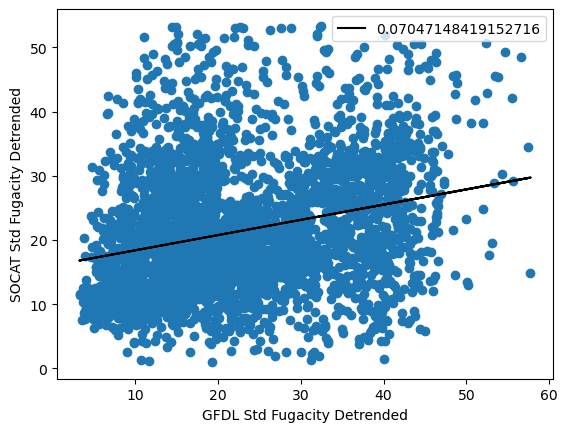

In [87]:
var1 = 'SOCAT Std Fugacity Detrended'
var2 = 'GFDL Std Fugacity Detrended'
newdf = rmoutliers(tempdf, var1)
newdf = rmoutliers(newdf, var2)

# plt.scatter(tempdf[var2], tempdf[var1], color = 'red')
plt.scatter(newdf[var2], newdf[var1])
plt.xlabel(var2)
plt.ylabel(var1)

x = newdf[var2]
y = newdf[var1]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
plt.plot(newdf[var2], predictions, color = 'black', label = model.rsquared)
plt.legend()

In [90]:
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     SOCAT Std Fugacity Detrended   R-squared:                       0.070
Model:                                      OLS   Adj. R-squared:                  0.070
Method:                           Least Squares   F-statistic:                     268.3
Date:                          Sun, 21 May 2023   Prob (F-statistic):           3.49e-58
Time:                                  19:06:35   Log-Likelihood:                -13019.
No. Observations:                          3541   AIC:                         2.604e+04
Df Residuals:                              3539   BIC:                         2.605e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------

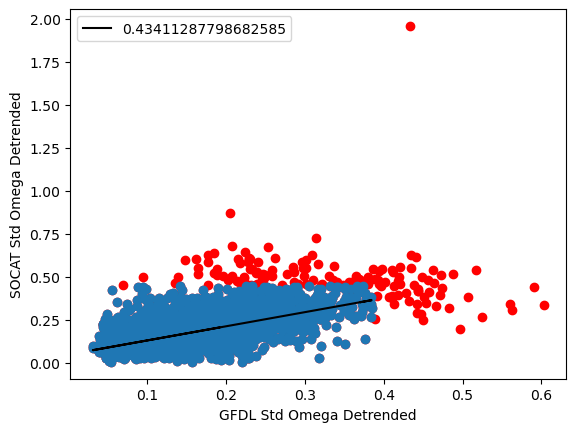

In [86]:
var1 = 'SOCAT Std Omega Detrended'
var2 = 'GFDL Std Omega Detrended'
newdf = rmoutliers(tempdf, var1)
newdf = rmoutliers(newdf, var2)

plt.scatter(tempdf[var2], tempdf[var1], color = 'red')
plt.scatter(newdf[var2], newdf[var1])
plt.xlabel(var2)
plt.ylabel(var1)

x = newdf[var2]
y = newdf[var1]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
plt.plot(newdf[var2], predictions, color = 'black', label = model.rsquared)
plt.legend()



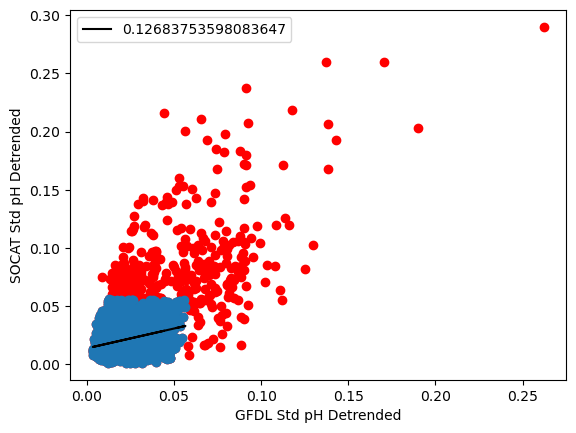

In [91]:
var1 = 'SOCAT Std pH Detrended'
var2 = 'GFDL Std pH Detrended'
newdf = rmoutliers(tempdf, var1)
newdf = rmoutliers(newdf, var2)

plt.scatter(tempdf[var2], tempdf[var1], color = 'red')
plt.scatter(newdf[var2], newdf[var1])
plt.xlabel(var2)
plt.ylabel(var1)

x = newdf[var2]
y = newdf[var1]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
plt.plot(newdf[var2], predictions, color = 'black', label = model.rsquared)
plt.legend()

In [94]:
tempdf[var2].dropna().shape

(3828,)

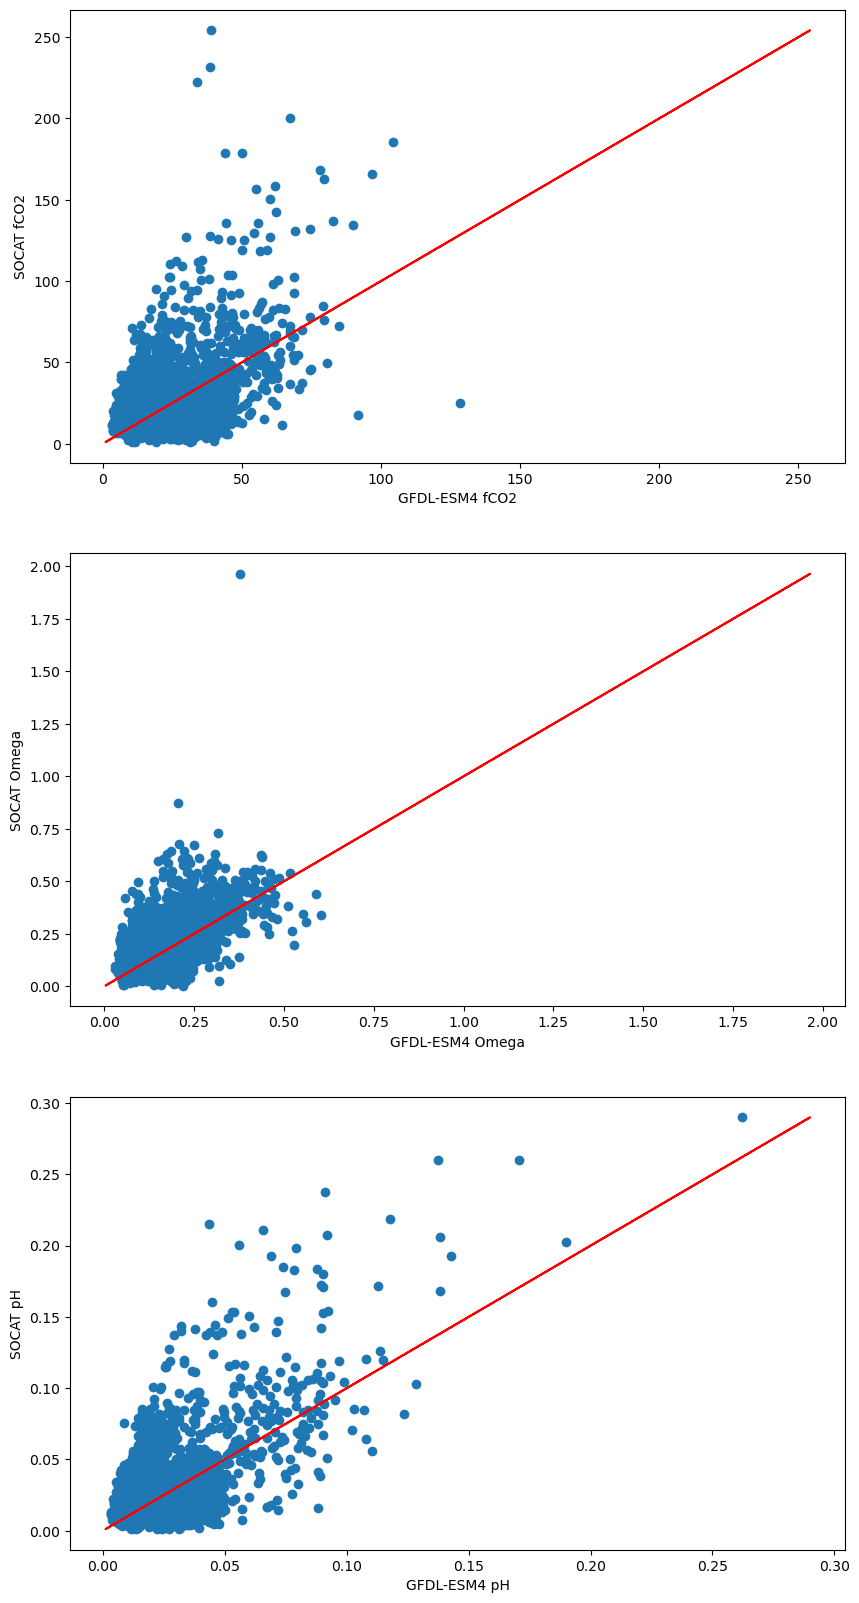

In [80]:
fig, axs = plt.subplots(nrows = 3, figsize = [10,20])
axs = axs.flatten()

axs[0].scatter(tempdf['GFDL Std Fugacity Detrended'], tempdf['SOCAT Std Fugacity Detrended'])
axs[0].plot(tempdf['SOCAT Std Fugacity Detrended'], tempdf['SOCAT Std Fugacity Detrended'], color = 'red')
axs[0].set_xlabel('GFDL-ESM4 fCO2')
axs[0].set_ylabel('SOCAT fCO2')

axs[1].scatter(tempdf['GFDL Std Omega Detrended'], tempdf['SOCAT Std Omega Detrended'])
axs[1].plot(tempdf['SOCAT Std Omega Detrended'], tempdf['SOCAT Std Omega Detrended'], color = 'red')
axs[1].set_xlabel('GFDL-ESM4 Omega')
axs[1].set_ylabel('SOCAT Omega')

axs[2].scatter(tempdf['GFDL Std pH Detrended'], tempdf['SOCAT Std pH Detrended'])
axs[2].plot(tempdf['SOCAT Std pH Detrended'], tempdf['SOCAT Std pH Detrended'], color = 'red')
axs[2].set_xlabel('GFDL-ESM4 pH')
axs[2].set_ylabel('SOCAT pH')

fig.savefig('/Users/akbaskind/Desktop/YoE/GFDLESM4_v_SOCAT_Apr30.png', bbox_inches='tight')

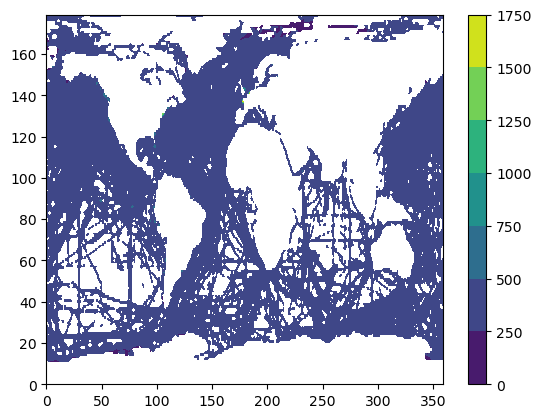

In [120]:
im = plt.contourf(np.nanmean(fco2[:,:,:], axis = 0))
plt.colorbar(im)

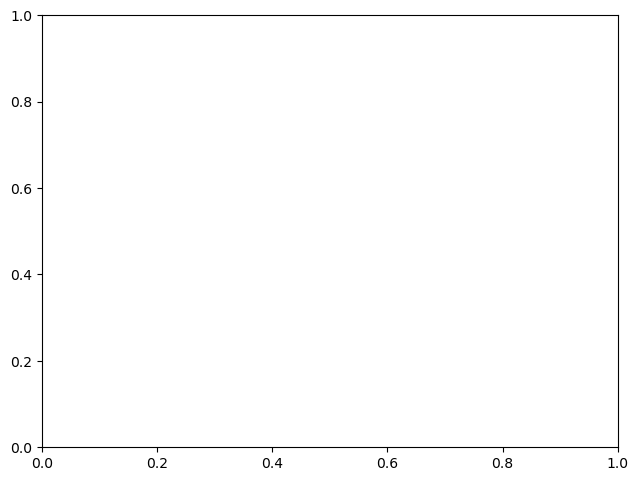

In [135]:
fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])

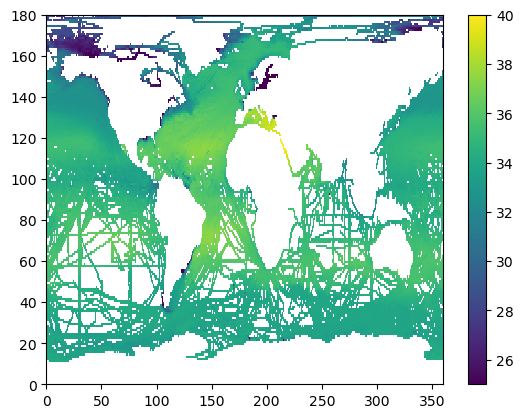

In [134]:
im = plt.pcolormesh(np.nanmean(s[:,:,:], axis = 0), vmin = 25, vmax = 40)
plt.colorbar(im)

In [106]:
np.mean(fgco2, axis = 0).shape

(180, 360)

In [45]:
type(tave_fco2)

numpy.ma.core.MaskedArray

In [46]:
tave_fco2.mask

False

In [47]:
tave_fco2[~tave_fco2.mask]

masked_array(
  data=[[[-9.9999255e+33, -9.9999255e+33, -9.9999255e+33, ...,
          -9.9999255e+33, -9.9999255e+33, -9.9999255e+33],
         [-9.9999255e+33, -9.9999255e+33, -9.9999255e+33, ...,
          -9.9999255e+33, -9.9999255e+33, -9.9999255e+33],
         [-9.9999255e+33, -9.9999255e+33, -9.9999255e+33, ...,
          -9.9999255e+33, -9.9999255e+33, -9.9999255e+33],
         ...,
         [-9.9518495e+33, -9.9678746e+33, -9.9678746e+33, ...,
          -9.9358244e+33, -9.9358244e+33, -9.9358244e+33],
         [-9.9678746e+33, -9.9678746e+33, -9.9839004e+33, ...,
          -9.9839004e+33, -9.9839004e+33, -9.9678746e+33],
         [-9.9678746e+33, -9.9678746e+33, -9.9678746e+33, ...,
          -9.9839004e+33, -9.9839004e+33, -9.9839004e+33]]],
  mask=False,
  fill_value=-1e+34,
  dtype=float32)

In [51]:
31680/7

4525.714285714285

In [52]:
4525.714285714285/24

188.57142857142856

In [53]:
188.57142857142856/60

3.142857142857143